# Operations and modelling optimization

## Non-linear modeling

### Minimizing cost in the supply of one commodity from several plants

$$
\text{min} \quad \sum_{i \in I} \sum_{t \in T} \left( a_i P_{i,t}^2 + b_i P_{i,t} + c_i \right)
$$

### Showing data for ideas related to Product Management:

* Which plants should operate to reduce costs?
* Is there any risk to supply market?

Data offer multiple options for further discussions in terms of product management, marketing / sales or supply chain

## About software used

Both Python and the solver used (ipopt) are freely available.

This model is also compatible with commercial optimization solvers, like Gurobi, just changing one single line of code will do the work.

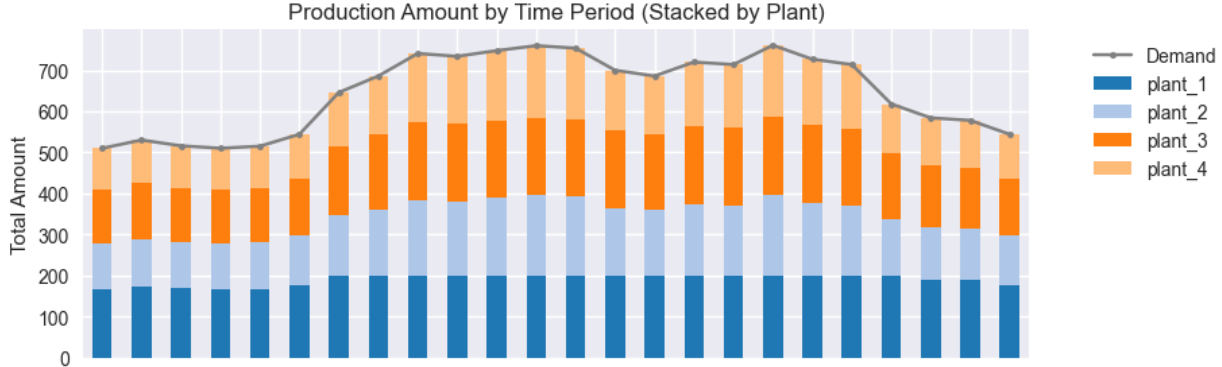

## Importing libraries

In [1]:
import numpy as np
import pandas as pd
import pyomo.environ as pyo

import matplotlib.pyplot as plt  # Graphics (normal)
from cycler import cycler

plt.style.use('seaborn-v0_8') # Style for matplotlib charts (optional, but makes easier to read charts)
plt.rcParams['figure.figsize'] = [9.3, 3.5] # Size for matplotlib charts (optional, but useful) 
plt.rcParams['axes.prop_cycle'] = cycler(color=plt.get_cmap('tab20').colors)  #tab20b

## Creation of the model

A 'concrete' (normal, with data, not an abstract one with only undefined variables)

### Model initialization

In [2]:
model = pyo.ConcreteModel()

Model is created, it is empty at the very beginning

In [3]:
model.pprint()

0 Declarations: 


### Data delivered from problem reality

In [4]:
plant_data = pd.DataFrame(
                          {'plant':  ['plant_1', 'plant_2', 'plant_3', 'plant_4'],  # plant name
                           'p_min':  [28, 20, 30, 20],                              # minimum production
                           'p_max':  [200, 290, 190, 260],                          # maximum production
                           'r_up':   [40, 30, 30, 50],                              # maximum production increase for ramp-up
                           'r_down': [40, 30, 30, 50],                              # maximum production drop for ramp-down
                           'a': [0.12, 0.17, 0.15, 0.19],                           # Cost = a * production^2 + b * production + c
                           'b': [14.8, 16.57, 15.55, 16.21],
                           'c': [89, 83, 100, 70]                              
                          }    
                         )

plant_data.index = plant_data.plant
plant_data = plant_data.drop(columns='plant')

In [5]:
T = [globals().get(f't_{i}', f't_{i}') for i in range(1, 25)]

In [6]:
demand_data = pd.Series(
                     [510, 530, 516, 510, 515, 544,                       
                      646, 686, 741, 734, 748, 760,
                      754, 700, 686, 720, 714, 761,
                      727, 714, 618, 584, 578, 544
                     ], index=T
                     )

### Defining sets (indices)

* Index I will be referring to plants
* Index t will be referring to time periods

In [7]:
model.I = pyo.Set(initialize=plant_data.index, doc= 'plants')
model.T = pyo.Set(initialize=demand_data.index, doc= 'time periods')

In [8]:
# Run in to check good progress at creating the model

# model.pprint()

### Defining parameters

* a[i]: Cost = a * production^2 + b * production + c for plant i
* b[i]: Cost = a * production^2 + b * production + c for plant i
* c[j]: Cost = a * production^2 + b * production + c for plant i
* p_min[i]:  minimum production for plant i
* p_max[i]:  maximum production for plant i
* r_up[i]:   maximum production increase for ramp-up of plant i
* r_down[i]: maximum production drop for ramp-down of plant i
* pd[t]: production demand in time period t

In [9]:
model.a = pyo.Param(
                    model.I,
                    initialize = plant_data[['a']],
                    doc='a coefficient in Cost = a * production^2 + b * production + c for plant i'
                    )

model.b = pyo.Param(
                    model.I,
                    initialize = plant_data[['b']],
                    doc='b coefficient in Cost = a * production^2 + b * production + c for plant i'
                    )

model.c = pyo.Param(
                    model.I,
                    initialize = plant_data[['c']],
                    doc='c coefficient in Cost = a * production^2 + b * production + c for plant i'
                    )

model.p_min = pyo.Param(
                    model.I,
                    initialize = plant_data[['p_min']],
                    doc='minimum production for plant i'
                    )

model.p_max = pyo.Param(
                    model.I,
                    initialize = plant_data[['p_max']],
                    doc='maximum production for plant i'
                    )

model.r_up = pyo.Param(
                    model.I,
                    initialize = plant_data[['r_up']],
                    doc='maximum production increase for ramp-up of plant i'
                    )

model.r_down = pyo.Param(
                    model.I,
                    initialize = plant_data[['r_down']],
                    doc='maximum production drop for ramp-down of plant i'
                    )

model.pd = pyo.Param(
                    model.T,
                    initialize = demand_data,
                    doc='production demand in time period t'
                    )

In [10]:
# Run in to check good progress at creating the model

# model.pprint()

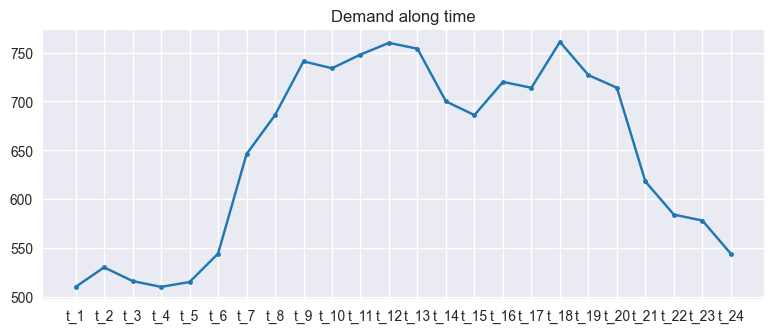

In [11]:
plt.plot(demand_data, marker='.')
plt.title('Demand along time')
plt.show()

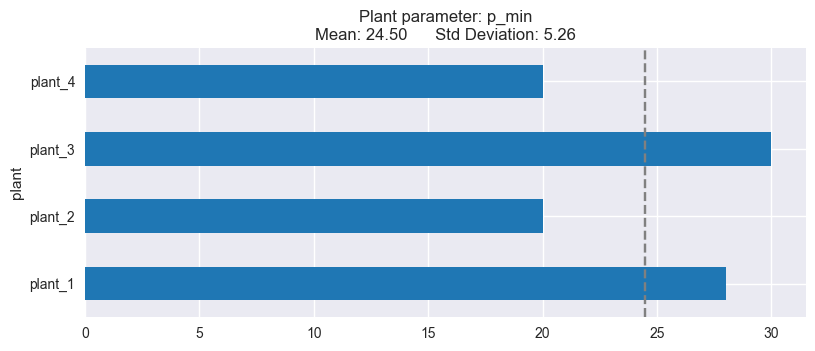

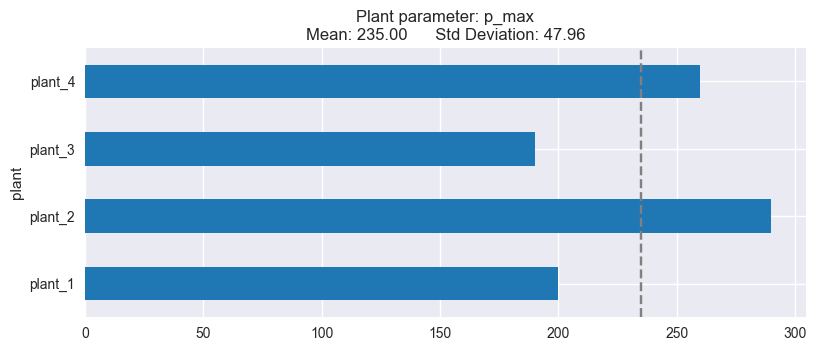

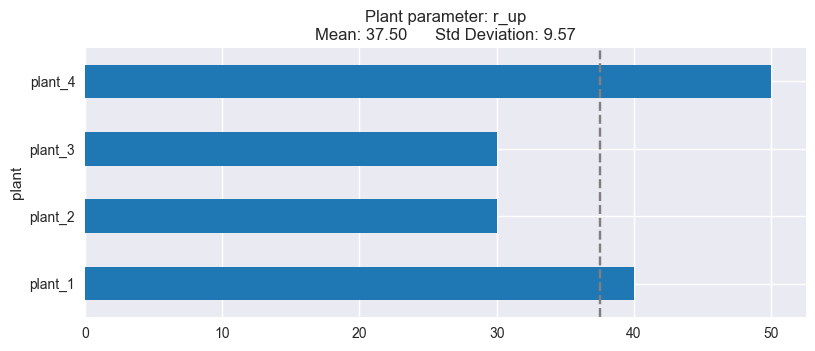

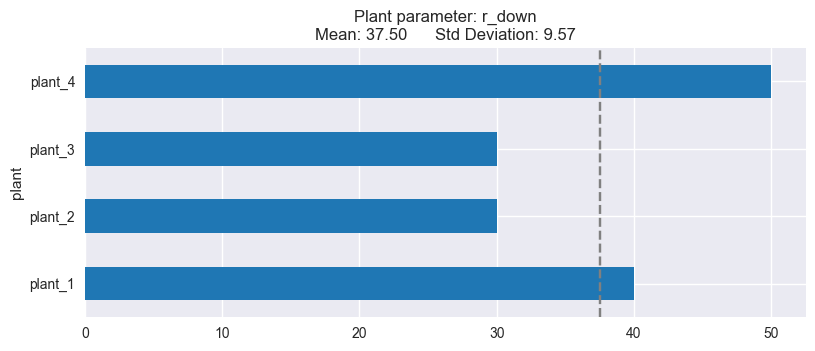

In [12]:
for variable in ['p_min', 'p_max', 'r_up', 'r_down']:
    plant_data[variable].plot(kind='barh')
    plt.axvline(plant_data[variable].mean(), color='gray', linestyle='--')
    plt.title(f'Plant parameter: {variable}\nMean: {plant_data[variable].mean():,.2f}      Std Deviation: {plant_data[variable].std():,.2f}')
    plt.show()
    

Insights from these charts:

* Plant 2 and Plant 4 are the plants with the bigger max and min production capability, delivering long-term production flexibility
* Plant 1 and Plant 4 are the plants with the bigger ramp-up and ramp-down, delivering short-term production flexibility

### Defining decision variables

* P[i, t]: amount to produce in plant i in time period t
* Bounds: p_min[i], p_max[i] for plant i 

In [13]:
def variable_bound_definition(model, i, t):
    output = (model.p_min[i], model.p_max[i])
    return output

model.P = pyo.Var(model.I, model.T,
                  bounds=variable_bound_definition,
                  doc='amount to produce in plant i in time period t'
                  )

In [14]:
# Run in to check good progress at creating the model

# model.pprint()

### Defining objective to optimize

Miminize cost of production

$$
\text{min} \quad \sum_{i \in I} \sum_{t \in T} \left( a_i P_{i,t}^2 + b_i P_{i,t} + c_i \right)
$$

In [15]:
def problem_objective(model):
    output = sum(
                 model.a[i] * model.P[i, t] ** 2 + model.b[i] * model.P[i, t] + model.c[i] for i in model.I for t in model.T
                )
    return output

In [16]:
model.cost = pyo.Objective(expr=problem_objective,
                           sense= pyo.minimize,
                           doc= 'objective function: minimize cost'
                          )

In [17]:
# Run in to check good progress at creating the model

# model.pprint()

### Defining constraints

* Fulfill demand: pd[t] = sum(P[i,t]) for each plant i at each time period t
* Ramp-up production constraint for each plant i
* Ramp-down production constraint for each plant i

Fulfill demand constraint

$$
\text{Demand Fulfillment:} \quad \forall t \in T, \quad \sum_{i \in I} P_{i,t} = pd_t
$$

In [18]:
def demand_fulfillment(model, t):
    output = (model.pd[t] == sum(model.P[i, t] for i in model.I) )
    return output

model.demand = pyo.Constraint(model.T,
                              expr=demand_fulfillment,
                              doc='total demand constraint, be realistic with available capacity'
                             )

In [19]:
# Run in to check good progress at creating the model

# model.pprint()

Ramp-up production constraint.

To avoid severe changes in production throughput in each plant

$$
\text{Ramp-Up Constraint:} \quad
\begin{cases}
P_{i,t+1} - P_{i,t} \leq r\_up_i, & \text{if } t \neq \max(T) \\
- P_{i,t} \leq r\_up_i, & \text{if } t = \max(T)
\end{cases}
$$

In [20]:
def ramp_up_constraint(model, i, t):
    if t != model.T.last():    # If time is not the last time
        t_index = list(model.T).index(t)
        t_next = list(model.T)[t_index+1]
        output = ( model.P[i, t_next] - model.P[i, t] <= model.r_up[i] )
        return output
    else:
        output = ( 0 - model.P[i, t] <= model.r_up[i] )  # Assumes that plant will shut down after last time period
        return output        

In [21]:
model.ramp_up = pyo.Constraint(model.I, model.T,
                              expr=ramp_up_constraint,
                              doc='ramp-up constraint (a particular constraint for this specific model'
                             )

In [22]:
# Run in to check good progress at creating the model

# model.pprint()

Ramp-down production constraint.

To avoid severe changes in production throughput in each plant

$$
\text{Ramp-Down Constraint:} \quad
\begin{cases}
P_{i,t-1} - P_{i,t} \leq r\_down_i, & \text{if } t \neq \min(T) \\
- P_{i,t} \leq r\_down_i, & \text{if } t = \min(T)
\end{cases}
$$

In [23]:
def ramp_down_constraint(model, i, t):
    if t != model.T.first():    # If time is not the last time
        t_index = list(model.T).index(t)
        t_previous = list(model.T)[t_index-1]
        output = ( model.P[i, t_previous] - model.P[i, t] <= model.r_down[i] )
        return output
    else:
        output = ( 0 - model.P[i, t] <= model.r_down[i] )  # Assumes that plant will shut down after last time period
        return output  

In [24]:
model.ramp_down = pyo.Constraint(model.I, model.T,
                              expr=ramp_down_constraint,
                              doc='ramp-down constraint (a particular constraint for this specific model'
                             )

### Showing final model

In [25]:
model.pprint()

2 Set Declarations
    I : plants
        Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    4 : {'plant_1', 'plant_2', 'plant_3', 'plant_4'}
    T : time periods
        Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :   24 : {'t_1', 't_2', 't_3', 't_4', 't_5', 't_6', 't_7', 't_8', 't_9', 't_10', 't_11', 't_12', 't_13', 't_14', 't_15', 't_16', 't_17', 't_18', 't_19', 't_20', 't_21', 't_22', 't_23', 't_24'}

8 Param Declarations
    a : a coefficient in Cost = a * production^2 + b * production + c for plant i
        Size=4, Index=I, Domain=Any, Default=None, Mutable=False
        Key     : Value
        plant_1 :  0.12
        plant_2 :  0.17
        plant_3 :  0.15
        plant_4 :  0.19
    b : b coefficient in Cost = a * production^2 + b * production + c for plant i
        Size=4, Index=I, Domain=Any, Default=None, Mutable=False
        Key     

## Solving the model

Choice of solver:

* Linear programming or not: non-linear
* License-free (glpk or cbc for linear, ipopt for non-linear) or paying license (Gurobi)

In [26]:
# Pick the one you prefer for linear programming problems

#solver = pyo.SolverFactory('glpk', executable=r'C:\WinPy3123\glpk-4.65\w64\glpsol.exe')
#solver = pyo.SolverFactory('cbc', executable=r'C:\WinPy3123\CBC\bin\cbc.exe')

# Pick this for non-linear programming problems

solver = pyo.SolverFactory('ipopt', executable=r'C:\WinPy3123\Ipopt-3.14.19-win64-msvs2022-md\bin\ipopt.exe')

In [27]:
results = solver.solve(model)

In [28]:
print(results)


Problem: 
- Lower bound: -.inf
  Upper bound: .inf
  Number of objectives: 1
  Number of constraints: 216
  Number of variables: 96
  Sense: unknown
Solver: 
- Status: ok
  Message: Ipopt 3.14.19\x3a Optimal Solution Found
  Termination condition: optimal
  Id: 0
  Error rc: 0
  Time: 0.23231196403503418
Solution: 
- number of solutions: 0
  number of solutions displayed: 0



In [29]:
# Load results into the model
model.solutions.load_from(results)

# Print objective function value
for obj in model.component_objects(pyo.Objective, active=True):
    print(f"Objective ({obj.name}) = {pyo.value(obj):,.2f}")

# Display variable values
print()
for v in model.component_objects(pyo.Var, active=True):
    print(f"Variable: {v.name}")
    for index in v:
        print(f"  {index} = {pyo.value(v[index]):,.2f}")

# Display constraint values
print()
print("Constraint Evaluations:")
for c in model.component_objects(pyo.Constraint, active=True):
    print()
    print(f" Constraint: {c.name}")
    for index in c:
        body_value = pyo.value(c[index].body)
        lower = c[index].lower
        upper = c[index].upper
        print(f"  {index}: {body_value:,.2f} ∈ [{lower}, {upper}]")


Objective (cost) = 647,964.46

Variable: P
  ('plant_1', 't_1') = 166.19
  ('plant_1', 't_2') = 172.57
  ('plant_1', 't_3') = 168.10
  ('plant_1', 't_4') = 166.19
  ('plant_1', 't_5') = 167.78
  ('plant_1', 't_6') = 177.03
  ('plant_1', 't_7') = 200.00
  ('plant_1', 't_8') = 200.00
  ('plant_1', 't_9') = 200.00
  ('plant_1', 't_10') = 200.00
  ('plant_1', 't_11') = 200.00
  ('plant_1', 't_12') = 200.00
  ('plant_1', 't_13') = 200.00
  ('plant_1', 't_14') = 200.00
  ('plant_1', 't_15') = 200.00
  ('plant_1', 't_16') = 200.00
  ('plant_1', 't_17') = 200.00
  ('plant_1', 't_18') = 200.00
  ('plant_1', 't_19') = 200.00
  ('plant_1', 't_20') = 200.00
  ('plant_1', 't_21') = 198.03
  ('plant_1', 't_22') = 189.78
  ('plant_1', 't_23') = 187.86
  ('plant_1', 't_24') = 177.03
  ('plant_2', 't_1') = 112.11
  ('plant_2', 't_2') = 116.60
  ('plant_2', 't_3') = 113.46
  ('plant_2', 't_4') = 112.11
  ('plant_2', 't_5') = 113.23
  ('plant_2', 't_6') = 119.75
  ('plant_2', 't_7') = 145.85
  ('plant_2'

# Analyzing results

## How much was produced in each plant along time?

In [30]:
plant_results = pd.DataFrame(
                             [(i, t, pyo.value(model.P[i, t])) for (i, t) in model.P],
                             columns=['plant', 'time_period', 'amount']    
                            )

Adding a column of time_period_number to improve result display afterwards

In [31]:
plant_results['time_period_number'] = plant_results.time_period.str.extract(r'_(\d+)').astype(int)

### Plotting analysis results

Time evolution of amount proced for each plants (view: all plants together)

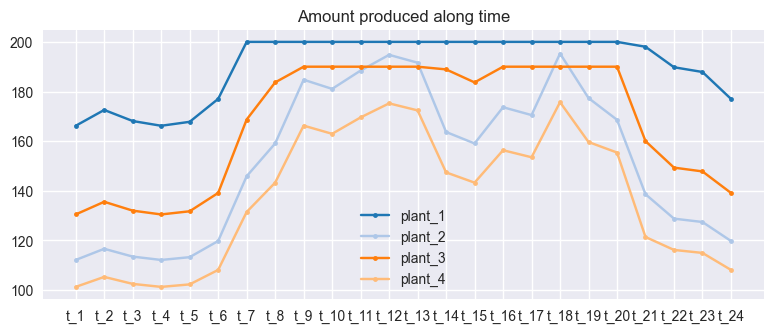

In [32]:
for plant in sorted(plant_results.plant.unique().tolist()):
    filter = plant_results.loc[plant_results.plant == plant]
    plt.plot(filter.time_period, filter.amount, label=plant, marker='.')
    plt.title('Amount produced along time')
    plt.legend(loc='best')


Alternative view using bars

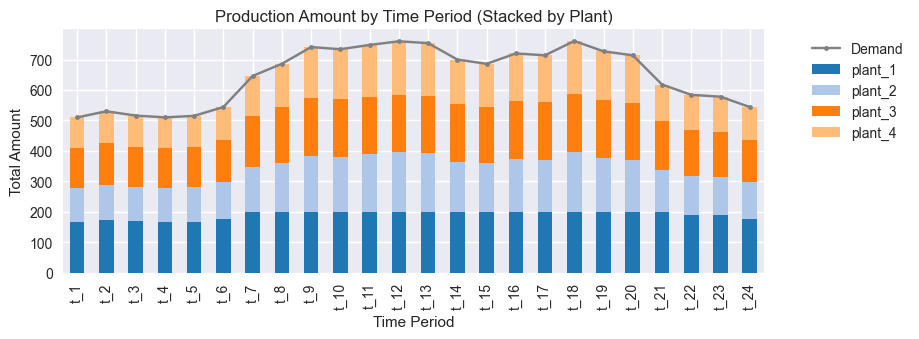


Production amount by plant along time:


plant,plant_1,plant_2,plant_3,plant_4
time_period,,,,
t_1,166.19,112.11,130.45,101.25
t_2,172.57,116.60,135.55,105.28
t_3,168.10,113.46,131.98,102.46
t_4,166.19,112.11,130.45,101.25
t_5,167.78,113.23,131.73,102.26
t_6,177.03,119.75,139.12,108.10
t_7,200.00,145.85,168.70,131.45
t_8,200.00,159.06,183.67,143.27
t_9,200.00,184.75,190.00,166.25


In [33]:

# Pivot the data to get plants as columns, time_periods as rows
#pivot_df = plant_results.pivot_table(index='time_period', columns='plant', values='amount', aggfunc='sum', fill_value=0)
query = (
    plant_results
    .groupby(['time_period', 'time_period_number', 'plant'])['amount']
    .sum()
    .unstack()
    .sort_values(by='time_period_number')
    .reset_index(level='time_period_number', drop=True)
)




# Plot stacked bar chart
query.plot(kind='bar', stacked=True)

plt.plot(demand_data, marker='.', color='gray', label='Demand')

# Customize the chart
plt.title('Production Amount by Time Period (Stacked by Plant)')
plt.xlabel('Time Period')
plt.ylabel('Total Amount')
plt.legend(bbox_to_anchor=(1.05, 1), loc='best')
plt.tight_layout()
plt.show()

print()
print('Production amount by plant along time:')
display(query.style.format("{:,.2f}"))

## How much production capacity was used in each plant?

In [34]:
plant_results['capacity_used'] = 100 * plant_results['amount'] / plant_results['plant'].map(plant_data['p_max'])

### Plotting analysis results

Detailed view for each plant

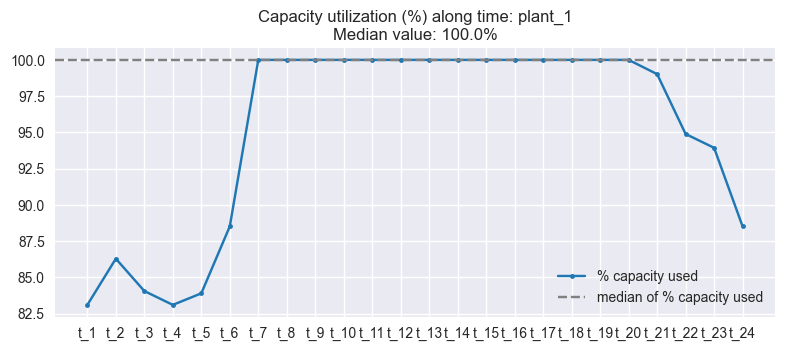

,plant,time_period,amount,capacity_used
0,plant_1,t_1,166.190547,83.095273
1,plant_1,t_2,172.565127,86.282564
2,plant_1,t_3,168.102921,84.051460
3,plant_1,t_4,166.190547,83.095273
4,plant_1,t_5,167.784192,83.892096
5,plant_1,t_6,177.027334,88.513667
6,plant_1,t_7,200.000002,100.000001
7,plant_1,t_8,200.000002,100.000001
8,plant_1,t_9,200.000002,100.000001
9,plant_1,t_10,200.000002,100.000001


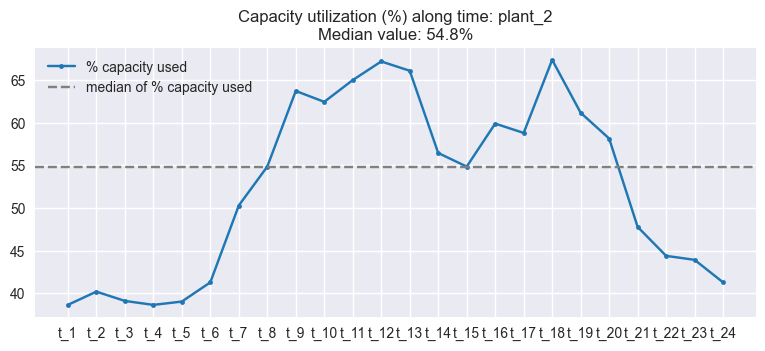

,plant,time_period,amount,capacity_used
24,plant_2,t_1,112.105092,38.656928
25,plant_2,t_2,116.604796,40.208550
26,plant_2,t_3,113.455003,39.122415
27,plant_2,t_4,112.105092,38.656928
28,plant_2,t_5,113.230018,39.044834
29,plant_2,t_6,119.754589,41.294686
30,plant_2,t_7,145.852838,50.294082
31,plant_2,t_8,159.062572,54.849163
32,plant_2,t_9,184.749998,63.706896
33,plant_2,t_10,181.055553,62.432949


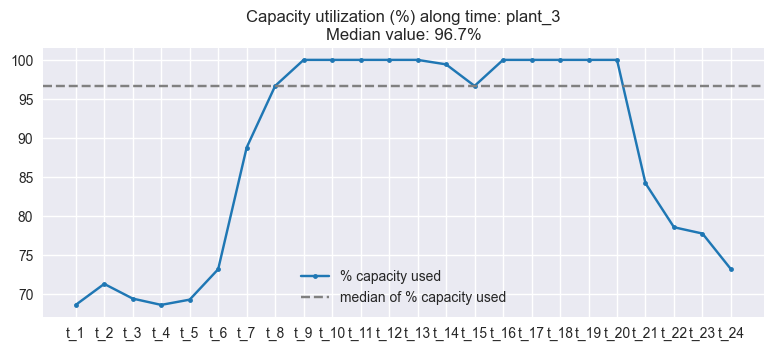

,plant,time_period,amount,capacity_used
48,plant_3,t_1,130.452437,68.659178
49,plant_3,t_2,135.552102,71.343211
50,plant_3,t_3,131.982337,69.464388
51,plant_3,t_4,130.452437,68.659178
52,plant_3,t_5,131.727353,69.330186
53,plant_3,t_6,139.121867,73.222035
54,plant_3,t_7,168.699883,88.789412
55,plant_3,t_8,183.670915,96.668902
56,plant_3,t_9,190.000002,100.000001
57,plant_3,t_10,190.000002,100.000001


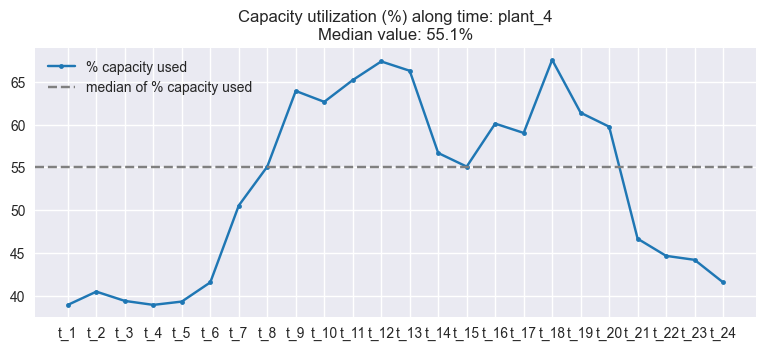

,plant,time_period,amount,capacity_used
72,plant_4,t_1,101.251924,38.943048
73,plant_4,t_2,105.277975,40.491529
74,plant_4,t_3,102.459739,39.407592
75,plant_4,t_4,101.251924,38.943048
76,plant_4,t_5,102.258437,39.330168
77,plant_4,t_6,108.096211,41.575466
78,plant_4,t_7,131.447276,50.556645
79,plant_4,t_8,143.266512,55.102504
80,plant_4,t_9,166.249998,63.942307
81,plant_4,t_10,162.944443,62.670939


In [35]:
for plant in sorted(plant_results.plant.unique().tolist()):
    filter = plant_results.loc[plant_results.plant == plant]
    plt.plot(filter.time_period, filter.capacity_used, label='% capacity used', marker='.')
    plt.axhline(filter.capacity_used.median(), linestyle='--', color='gray', label='median of % capacity used')
    plt.title(f'Capacity utilization (%) along time: {plant}\nMedian value: {filter.capacity_used.median():,.1f}%')
    plt.legend(loc='best')
    plt.show()
    display(filter[['plant', 'time_period', 'amount','capacity_used']])

View of all plants together

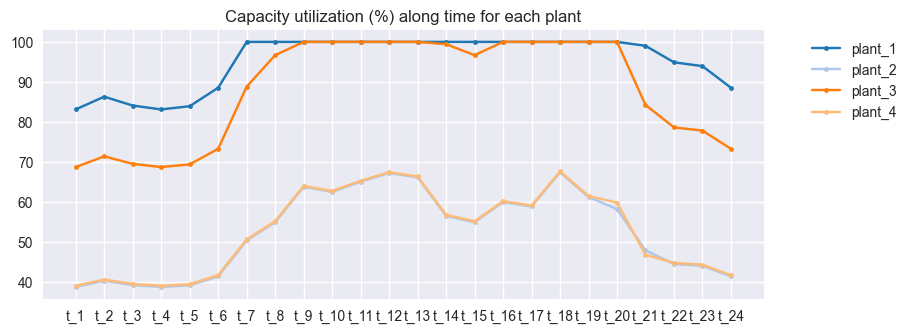


Results:


,plant,time_period,amount,capacity_used
0,plant_1,t_1,166.190547,83.095273
1,plant_1,t_2,172.565127,86.282564
2,plant_1,t_3,168.102921,84.051460
3,plant_1,t_4,166.190547,83.095273
4,plant_1,t_5,167.784192,83.892096
...,...,...,...,...
91,plant_4,t_20,155.397913,59.768428
92,plant_4,t_21,121.363709,46.678350
93,plant_4,t_22,116.148313,44.672428
94,plant_4,t_23,114.940497,44.207884


In [36]:
for plant in sorted(plant_results.plant.unique().tolist()):
    filter = plant_results.loc[plant_results.plant == plant]
    plt.plot(filter.time_period, filter.capacity_used, label=plant, marker='.')
    plt.title(f'Capacity utilization (%) along time for each plant')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='best')
plt.show()

print()
print('Results:')
display(plant_results[['plant', 'time_period', 'amount','capacity_used']])

## How much was the cost for each plant?

In [37]:
plant_results['cost'] = plant_results['plant'].map(plant_data['a']) * ( plant_results.amount ** 2 ) + (
                        plant_results['plant'].map(plant_data['b']) * ( plant_results.amount ) )  * 2 + (
                        plant_results['plant'].map(plant_data['c']) )                       

### Plotting analysis results

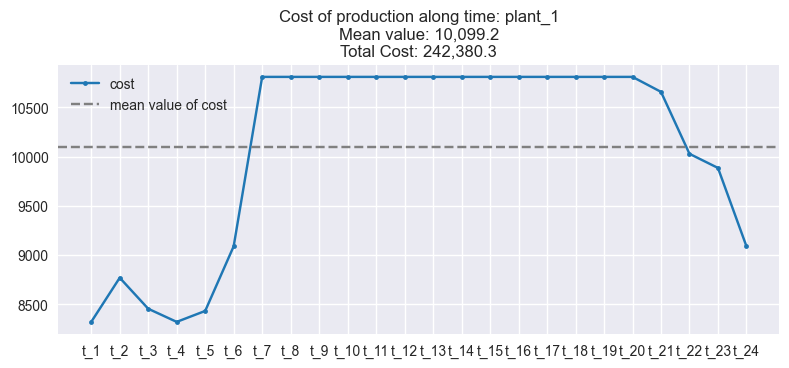

,plant,time_period,amount,capacity_used,cost
0,plant_1,t_1,166.190547,83.095273,8322.555918
1,plant_1,t_2,172.565127,86.282564,8770.374547
2,plant_1,t_3,168.102921,84.051460,8455.877498
3,plant_1,t_4,166.190547,83.095273,8322.555918
4,plant_1,t_5,167.784192,83.892096,8433.596281
5,plant_1,t_6,177.027334,88.513667,9089.650304
6,plant_1,t_7,200.000002,100.000001,10809.000155
7,plant_1,t_8,200.000002,100.000001,10809.000155
8,plant_1,t_9,200.000002,100.000001,10809.000155
9,plant_1,t_10,200.000002,100.000001,10809.000155


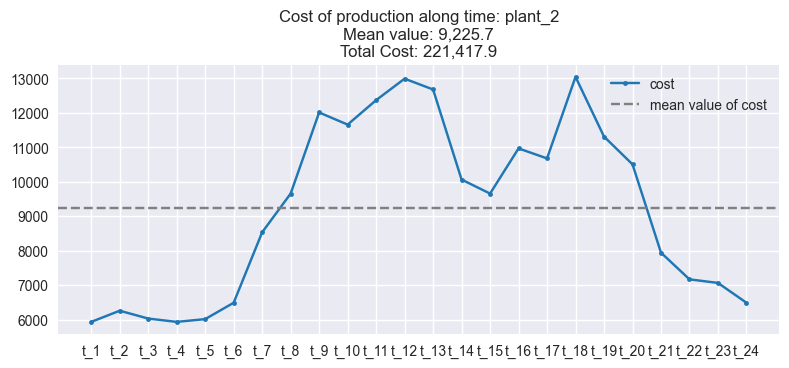

,plant,time_period,amount,capacity_used,cost
24,plant_2,t_1,112.105092,38.656928,5934.646513
25,plant_2,t_2,116.604796,40.208550,6258.718257
26,plant_2,t_3,113.455003,39.122415,6031.145207
27,plant_2,t_4,112.105092,38.656928,5934.646513
28,plant_2,t_5,113.230018,39.044834,6015.019065
29,plant_2,t_6,119.754589,41.294686,6489.664513
30,plant_2,t_7,145.852838,50.294082,8532.981634
31,plant_2,t_8,159.062572,54.849163,9655.486923
32,plant_2,t_9,184.749998,63.706896,12008.150427
33,plant_2,t_10,181.055553,62.432949,11655.970330


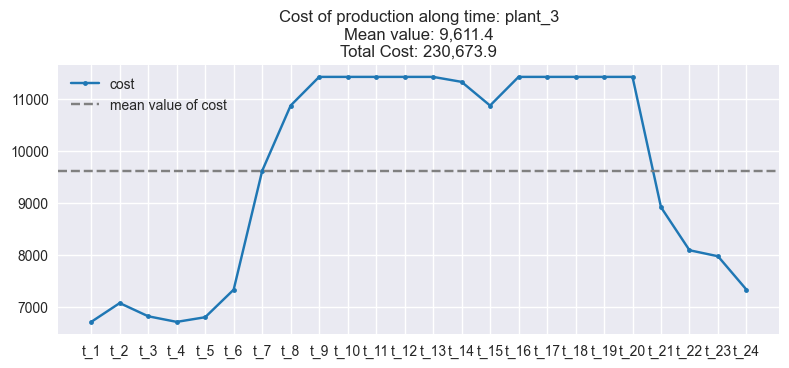

,plant,time_period,amount,capacity_used,cost
48,plant_3,t_1,130.452437,68.659178,6709.746562
49,plant_3,t_2,135.552102,71.343211,7071.826214
50,plant_3,t_3,131.982337,69.464388,6817.551251
51,plant_3,t_4,130.452437,68.659178,6709.746562
52,plant_3,t_5,131.727353,69.330186,6799.535040
53,plant_3,t_6,139.121867,73.222035,7329.924145
54,plant_3,t_7,168.699883,88.789412,9615.513970
55,plant_3,t_8,183.670915,96.668902,10872.416180
56,plant_3,t_9,190.000002,100.000001,11424.000167
57,plant_3,t_10,190.000002,100.000001,11424.000167


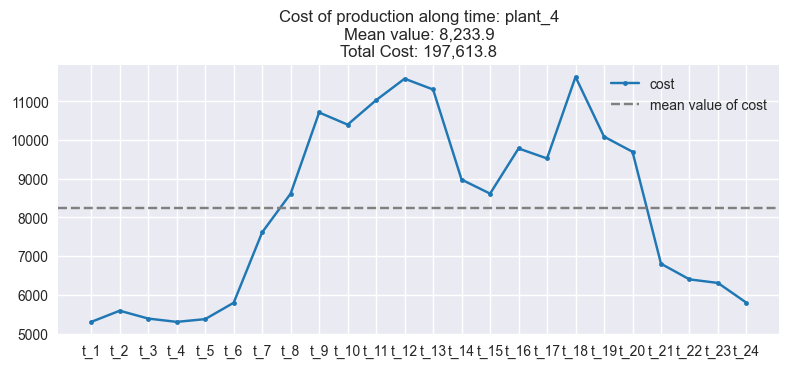

,plant,time_period,amount,capacity_used,cost
72,plant_4,t_1,101.251924,38.943048,5300.458293
73,plant_4,t_2,105.277975,40.491529,5588.967843
74,plant_4,t_3,102.459739,39.407592,5386.364415
75,plant_4,t_4,101.251924,38.943048,5300.458293
76,plant_4,t_5,102.258437,39.330168,5372.008232
77,plant_4,t_6,108.096211,41.575466,5794.589402
78,plant_4,t_7,131.447276,50.556645,7614.414127
79,plant_4,t_8,143.266512,55.102504,8614.506040
80,plant_4,t_9,166.249998,63.942307,10711.246699
81,plant_4,t_10,162.944443,62.670939,10397.328190


In [38]:
for plant in sorted(plant_results.plant.unique().tolist()):
    filter = plant_results.loc[plant_results.plant == plant]
    plt.plot(filter.time_period, filter.cost, label='cost', marker='.')
    plt.axhline(filter.cost.mean(), linestyle='--', color='gray', label='mean value of cost')
    plt.title(f'Cost of production along time: {plant}\nMean value: {filter.cost.mean():,.1f}\nTotal Cost: {filter.cost.sum():,.1f}')
    plt.legend(loc='best')
    plt.show()
    display(filter[['plant', 'time_period', 'amount','capacity_used', 'cost']])

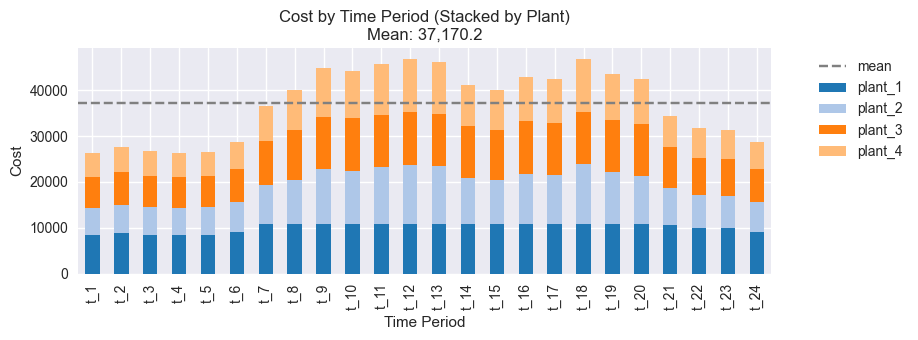


Cost by plant along time:


plant,plant_1,plant_2,plant_3,plant_4
time_period,,,,
t_1,"8,322.56","5,934.65","6,709.75","5,300.46"
t_2,"8,770.37","6,258.72","7,071.83","5,588.97"
t_3,"8,455.88","6,031.15","6,817.55","5,386.36"
t_4,"8,322.56","5,934.65","6,709.75","5,300.46"
t_5,"8,433.60","6,015.02","6,799.54","5,372.01"
t_6,"9,089.65","6,489.66","7,329.92","5,794.59"
t_7,"10,809.00","8,532.98","9,615.51","7,614.41"
t_8,"10,809.00","9,655.49","10,872.42","8,614.51"
t_9,"10,809.00","12,008.15","11,424.00","10,711.25"


In [39]:
query = (
    plant_results
    .groupby(['time_period', 'time_period_number', 'plant'])['cost']
    .sum()
    .unstack()
    .sort_values(by='time_period_number')
    .reset_index(level='time_period_number', drop=True)
)


# Plot stacked bar chart
query.plot(kind='bar', stacked=True)

plt.axhline(query.sum(axis=1).mean(), linestyle='--', color='gray', label='mean')

# Customize the chart
plt.title(f'Cost by Time Period (Stacked by Plant)\nMean: {query.sum(axis=1).mean():,.1f}')
plt.xlabel('Time Period')
plt.ylabel('Cost')
plt.legend(bbox_to_anchor=(1.05, 1), loc='best')
plt.tight_layout()
plt.show()

print()
print('Cost by plant along time:')
display(query.style.format("{:,.2f}"))

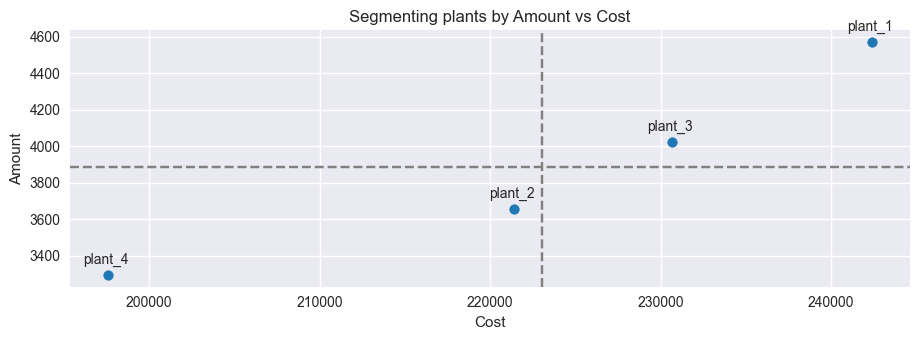

,amount,cost
plant,,
plant_1,"4,570.56","242,380.31"
plant_3,"4,020.48","230,673.88"
plant_2,"3,655.51","221,417.87"
plant_4,"3,293.45","197,613.77"


In [40]:
query = plant_results.groupby('plant')[['amount', 'cost']].sum()
plt.scatter(query.cost, query.amount)

# Annotate each point with its index
for i in query.index:
    plt.annotate(str(i), (query.cost[i], query.amount[i]), textcoords="offset points", xytext=(-18,8), ha='left')


plt.axvline(query.cost.mean(), linestyle='--', color='gray')
plt.axhline(query.amount.mean(), linestyle='--', color='gray')

plt.xlabel('Cost')
plt.ylabel('Amount')
plt.title('Segmenting plants by Amount vs Cost')
plt.tight_layout()
plt.show()

display(query.sort_values(by='cost', ascending=False).style.format("{:,.2f}"))

In [41]:
query['cost_over_amount'] = query.cost / query.amount

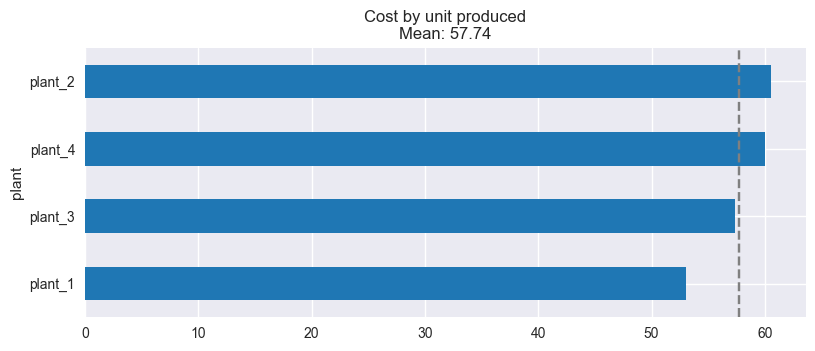

,amount,cost,cost_over_amount
plant,,,
plant_2,"3,655.51","221,417.87",60.57
plant_4,"3,293.45","197,613.77",60.00
plant_3,"4,020.48","230,673.88",57.37
plant_1,"4,570.56","242,380.31",53.03


In [42]:
query = query.sort_values(by='cost_over_amount')

query.cost_over_amount.plot(kind='barh')
plt.axvline(query.cost_over_amount.mean(), linestyle='--', color='gray')
plt.title(f'Cost by unit produced\nMean: {query.cost_over_amount.mean():,.2f}')
plt.show()

display(query.sort_values(by='cost_over_amount', ascending=False).style.format("{:,.2f}"))

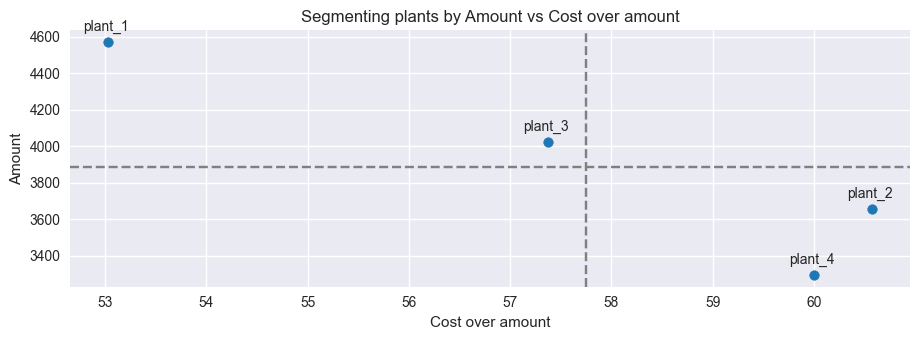

,amount,cost,cost_over_amount
plant,,,
plant_2,"3,655.51","221,417.87",60.57
plant_4,"3,293.45","197,613.77",60.00
plant_3,"4,020.48","230,673.88",57.37
plant_1,"4,570.56","242,380.31",53.03


In [43]:
plt.scatter(query.cost_over_amount, query.amount)

# Annotate each point with its index
for i in query.index:
    plt.annotate(str(i), (query.cost_over_amount[i], query.amount[i]), textcoords="offset points", xytext=(-18,8), ha='left')


plt.axvline(query.cost_over_amount.mean(), linestyle='--', color='gray')
plt.axhline(query.amount.mean(), linestyle='--', color='gray')

plt.xlabel('Cost over amount')
plt.ylabel('Amount')
plt.title('Segmenting plants by Amount vs Cost over amount')
plt.tight_layout()
plt.show()

display(query.sort_values(by='cost_over_amount', ascending=False).style.format("{:,.2f}"))